<h1>Transformer for Time Series Forecasting</h1>

<h2>Implementation from Scratch with Attention Mechanism</h2>

<p><b>Code written by Seetha Parameswaran</b></p>

<hr>

<h3>Overview</h3>
<p>This exercise demonstrates <b>Transformer encoder implementation from scratch</b> for time series forecasting. We build positional encoding and multi-head self-attention without using pre-trained models.</p>

<h4>Transformer Components:</h4>
<ul>
  <li><b>Positional Encoding</b>: Sinusoidal encoding (PE(pos, 2i) = sin, PE(pos, 2i+1) = cos)</li>
  <li><b>Multi-Head Attention</b>: Scaled dot-product attention with Q, K, V projections</li>
  <li><b>Encoder Block</b>: Attention + Feed-Forward + Layer Normalization + Residual</li>
  <li><b>No pre-training</b>: Built from scratch using Keras layers</li>
</ul>

<hr>

<h3>Learning Outcomes</h3>
<ul>
  <li>✓ Implement sinusoidal positional encoding</li>
  <li>✓ Build multi-head self-attention mechanism</li>
  <li>✓ Create transformer encoder blocks</li>
  <li>✓ Stack transformer layers with residual connections</li>
  <li>✓ Apply transformers to time series forecasting</li>
  <li>✓ Compare with RNN architectures</li>
</ul>

<hr>

<h3>Architecture</h3>
<pre>
Input (seq_length, n_features)
   ↓
Dense projection → d_model
   ↓
+ Positional Encoding
   ↓
Transformer Block × n_layers
  [Multi-Head Attention + FFN + LayerNorm]
   ↓
GlobalAveragePooling1D
   ↓
Dense (1) [univariate output]
</pre>

In [1]:
# Import Libraries
# Cell 1 (FIRST CELL)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import warnings
warnings.filterwarnings('ignore')

2026-01-13 09:41:05.681743: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 09:41:05.730632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 09:41:07.132668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/opt/conda/lib/pytho

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## PART 1: LOAD AND PREPROCESS TIME SERIES DATA

In [3]:
print("\n[1] Loading time series dataset...")

# Generate synthetic multivariate time series data
# Features: temperature, humidity, day_of_week (simulating energy consumption)
np.random.seed(42)
n_samples = 2000
time = np.arange(n_samples)

# Feature 1: Temperature (seasonal pattern)
temperature = 20 + 10 * np.sin(2 * np.pi * time / 365) + np.random.randn(n_samples) * 2

# Feature 2: Humidity (with trend)
humidity = 60 + 0.005 * time + 10 * np.sin(2 * np.pi * time / 180) + np.random.randn(n_samples) * 3

# Feature 3: Day of week (cyclic)
day_of_week = np.sin(2 * np.pi * time / 7)

# Target: Energy consumption (depends on temperature and humidity)
energy = (50 + 0.5 * temperature + 0.3 * humidity + 
          5 * np.sin(2 * np.pi * time / 7) + np.random.randn(n_samples) * 5)

# Create DataFrame
data = pd.DataFrame({
    'temperature': temperature,
    'humidity': humidity,
    'day_of_week': day_of_week,
    'energy': energy
})

print(f"Dataset shape: {data.shape}")
print(f"Features: {list(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())




[1] Loading time series dataset...
Dataset shape: (2000, 4)
Features: ['temperature', 'humidity', 'day_of_week', 'energy']

First few rows:
   temperature   humidity  day_of_week     energy
0    20.993428  57.974465     0.000000  73.571586
1    19.895605  59.920439     0.781831  81.677074
2    21.639593  58.330305     0.974928  83.283612
3    23.562256  60.136400     0.433884  84.354619
4    20.219718  55.730887    -0.433884  67.825414


## PART 2: TIME SERIES EXPLORATION AND VISUALIZATION

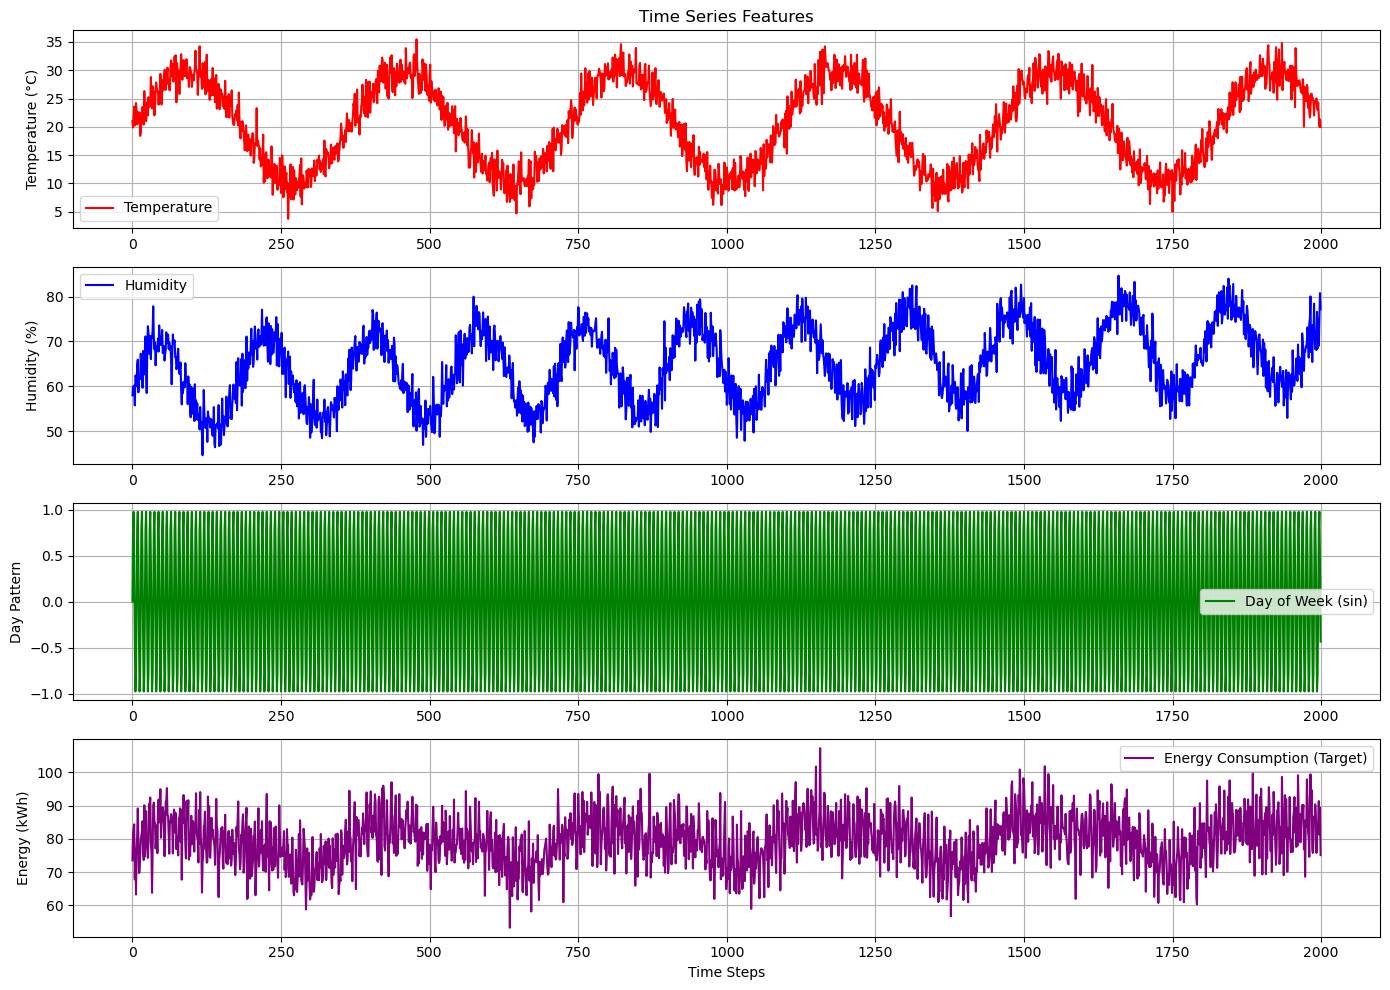

In [4]:
# Visualize time series
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(data['temperature'], label='Temperature', color='red')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Time Series Features')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(data['humidity'], label='Humidity', color='blue')
axes[1].set_ylabel('Humidity (%)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(data['day_of_week'], label='Day of Week (sin)', color='green')
axes[2].set_ylabel('Day Pattern')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(data['energy'], label='Energy Consumption (Target)', color='purple')
axes[3].set_ylabel('Energy (kWh)')
axes[3].set_xlabel('Time Steps')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()

## PART 2: DATA PREPROCESSING

In [5]:
print("\n[2] Preprocessing time series data...")

# Normalize features using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features
X_scaled = scaler_X.fit_transform(data[['temperature', 'humidity', 'day_of_week']])

# Scale target
y_scaled = scaler_y.fit_transform(data[['energy']])

# Create sequences for time series prediction
def create_sequences(X, y, seq_length, pred_horizon=1):
    """Create sequences for time series forecasting"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length - pred_horizon + 1):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length:i + seq_length + pred_horizon])
    
    return np.array(X_seq), np.array(y_seq)

# Configuration
sequence_length = 30  # Look back 30 time steps
prediction_horizon = 1  # Predict 1 step ahead

# Create sequences
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length, prediction_horizon)

print(f"\nSequence shapes:")
print(f"X_sequences: {X_sequences.shape} (samples, seq_length, n_features)")
print(f"y_sequences: {y_sequences.shape} (samples, pred_horizon)")

# Temporal train/test split (NO SHUFFLING)
train_size = int(0.9 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

print(f"\nTrain/Test Split (90/10 temporal):")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("IMPORTANT: Temporal split used (NO shuffling)")


[2] Preprocessing time series data...

Sequence shapes:
X_sequences: (1970, 30, 3) (samples, seq_length, n_features)
y_sequences: (1970, 1, 1) (samples, pred_horizon)

Train/Test Split (90/10 temporal):
Training samples: 1773
Test samples: 197
IMPORTANT: Temporal split used (NO shuffling)


## PART 3: POSITIONAL ENCODING IMPLEMENTATION


[3] Implementing Positional Encoding...
Positional encoding shape: (1, 30, 64)


2026-01-13 09:41:12.522945: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


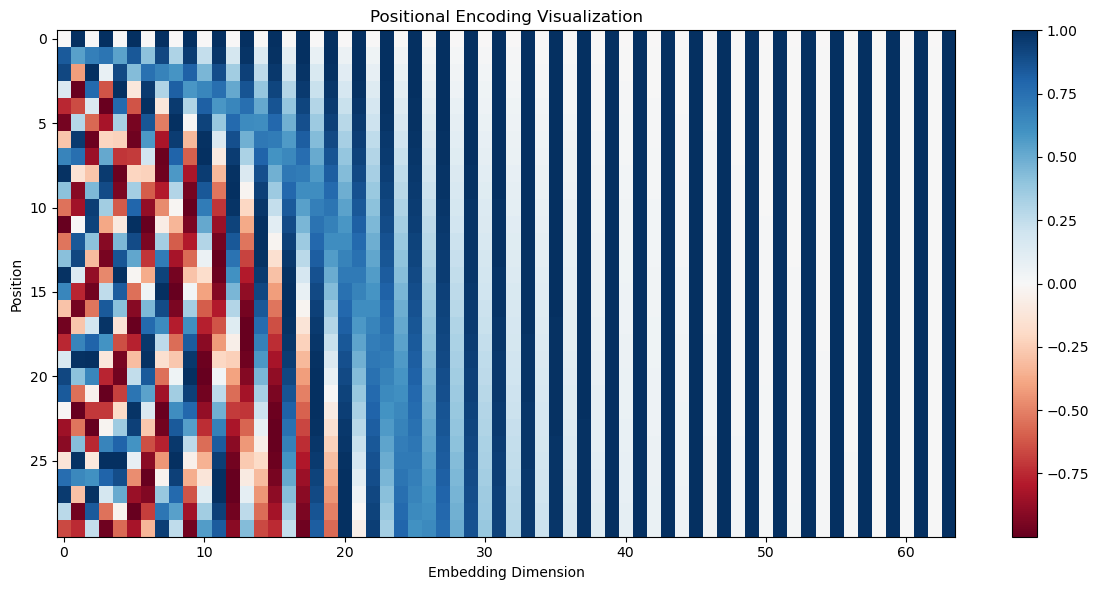

In [6]:
print("\n[3] Implementing Positional Encoding...")

def positional_encoding(seq_length, d_model):
    """
    Generate sinusoidal positional encodings
    
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    Args:
        seq_length: length of the sequence
        d_model: dimension of the model (embedding size)
    
    Returns:
        positional encodings: tensor of shape (1, seq_length, d_model)
    """
    # Create position indices
    position = np.arange(seq_length)[:, np.newaxis]  # (seq_length, 1)
    
    # Create dimension indices
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # Initialize positional encoding matrix
    pos_encoding = np.zeros((seq_length, d_model))
    
    # Apply sine to even indices
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    
    # Apply cosine to odd indices
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    
    # Add batch dimension
    pos_encoding = pos_encoding[np.newaxis, ...]  # (1, seq_length, d_model)
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Test positional encoding
d_model = 64
pos_enc = positional_encoding(sequence_length, d_model)
print(f"Positional encoding shape: {pos_enc.shape}")

# Visualize positional encoding
plt.figure(figsize=(12, 6))
plt.imshow(pos_enc[0], aspect='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Visualization')
plt.tight_layout()

## PART 4: MULTI-HEAD ATTENTION IMPLEMENTATION

In [8]:
print("\n[4] Implementing Multi-Head Attention...")

class MultiHeadAttention(layers.Layer):
    """
    Multi-head self-attention mechanism
    """
    
    def __init__(self, d_model, n_heads):
        """
        Initialize multi-head attention
        
        Args:
            d_model: dimension of the model
            n_heads: number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.depth = d_model // n_heads
        
        # Linear projections for Q, K, V
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        # Output projection
        self.dense = layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (n_heads, depth)
        Transpose to shape: (batch_size, n_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def scaled_dot_product_attention(self, q, k, v):
        """
        Compute scaled dot-product attention
        
        Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
        
        Args:
            q: queries (batch_size, n_heads, seq_len_q, depth)
            k: keys (batch_size, n_heads, seq_len_k, depth)
            v: values (batch_size, n_heads, seq_len_v, depth)
        
        Returns:
            output: attention output
            attention_weights: attention weights
        """
        # Calculate QK^T
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch, heads, seq_len_q, seq_len_k)
        
        # Scale by sqrt(d_k)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Apply softmax
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        # Multiply by V
        output = tf.matmul(attention_weights, v)  # (batch, heads, seq_len_q, depth)
        
        return output, attention_weights
    
    def call(self, x):
        """
        Forward pass through multi-head attention
        
        Args:
            x: input tensor (batch_size, seq_len, d_model)
        
        Returns:
            output: attention output (batch_size, seq_len, d_model)
        """
        batch_size = tf.shape(x)[0]
        
        # Linear projections
        q = self.wq(x)  # (batch_size, seq_len, d_model)
        k = self.wk(x)
        v = self.wv(x)
        
        # Split into multiple heads
        q = self.split_heads(q, batch_size)  # (batch_size, n_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Apply scaled dot-product attention
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v)
        
        # Concatenate heads
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # Final linear projection
        output = self.dense(concat_attention)
        
        return output

print("Multi-head attention layer implemented")


[4] Implementing Multi-Head Attention...
Multi-head attention layer implemented


## PART 5: TRANSFORMER ENCODER BLOCK

In [9]:
print("\n[5] Building Transformer Encoder Block...")

class TransformerEncoderBlock(layers.Layer):
    """
    Transformer encoder block with multi-head attention and feed-forward network
    """
    
    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        """
        Initialize transformer encoder block
        
        Args:
            d_model: dimension of the model
            n_heads: number of attention heads
            d_ff: dimension of feed-forward network
            dropout_rate: dropout rate
        """
        super(TransformerEncoderBlock, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, n_heads)
        
        self.ffn = keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, x, training):
        """
        Forward pass through transformer encoder block
        
        Args:
            x: input tensor
            training: boolean for dropout
        
        Returns:
            output tensor
        """
        # Multi-head attention with residual connection
        attn_output = self.mha(x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        # Feed-forward network with residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

print("Transformer encoder block implemented")


[5] Building Transformer Encoder Block...
Transformer encoder block implemented


## PART 6: BUILD TRANSFORMER MODEL

In [10]:
print("\n[6] Building complete Transformer model...")

def build_transformer_model(seq_length, n_features, d_model, n_heads, d_ff, n_layers, output_size):
    """
    Build Transformer encoder model for time series forecasting
    
    Args:
        seq_length: input sequence length
        n_features: number of input features
        d_model: dimension of the model (embedding size)
        n_heads: number of attention heads
        d_ff: dimension of feed-forward network
        n_layers: number of transformer encoder blocks
        output_size: prediction horizon
    
    Returns:
        model: compiled Transformer model
    """
    
    # Input layer
    inputs = layers.Input(shape=(seq_length, n_features))
    
    # Project input features to d_model dimensions
    x = layers.Dense(d_model)(inputs)
    
    # Add positional encoding
    pos_enc = positional_encoding(seq_length, d_model)
    x = x + pos_enc
    
    # Stack transformer encoder blocks
    for _ in range(n_layers):
        x = TransformerEncoderBlock(d_model, n_heads, d_ff)(x, training=True)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Output layer
    outputs = layers.Dense(output_size)(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


[6] Building complete Transformer model...


## PART 7: BUILD TRANSFORMER MODEL

In [11]:
# Model configuration
d_model = 64  # Embedding dimension
n_heads = 4  # Number of attention heads
d_ff = 128  # Feed-forward dimension
n_layers = 2  # Number of transformer blocks

# Build model
transformer_model = build_transformer_model(
    seq_length=sequence_length,
    n_features=X_train.shape[2],
    d_model=64,
    n_heads=4,
    d_ff=128,
    n_layers=2,
    output_size=prediction_horizon
)

# Compile model
transformer_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("\nTransformer Architecture:")
transformer_model.summary()


Transformer Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block       │ (None, 30, 64)         │        33,472 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_1     │ (None, 30, 64)         │        33,472 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,265 (262.75 KB)

 Trainable params: 67,265 (262.75 KB)

 Non-trainable params: 0 (0.00 B)

## PART 7: TRAIN TRANSFORMER MODEL

In [12]:
print("\n[7] Training Transformer model...")

# Train model
transformer_history = transformer_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)


[7] Training Transformer model...


In [13]:
# Track initial and final loss
transformer_initial_loss = transformer_history.history['loss'][0]
transformer_final_loss = transformer_history.history['loss'][-1]

print(f"Initial Loss: {transformer_initial_loss:.6f}")
print(f"Final Loss: {transformer_final_loss:.6f}")
print(f"Loss Decreased: {transformer_final_loss < transformer_initial_loss}")

Initial Loss: 0.301228
Final Loss: 0.010389
Loss Decreased: True


## PART 8: EVALUATE TRANSFORMER MODEL

In [16]:
print("\n[8] Evaluating Transformer model on test set...")

# Make predictions
transformer_pred_scaled = transformer_model.predict(X_test, verbose=0)
transformer_pred = scaler_y.inverse_transform(transformer_pred_scaled.reshape(-1, 1))

# Actual values
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

transformer_mae = mean_absolute_error(y_test_actual, transformer_pred)
transformer_rmse = np.sqrt(mean_squared_error(y_test_actual, transformer_pred))
transformer_mape = calculate_mape(y_test_actual, transformer_pred)
transformer_r2 = r2_score(y_test_actual, transformer_pred)

print("TRANSFORMER MODEL PERFORMANCE")
print(f"MAE:      {transformer_mae:.4f}")
print(f"RMSE:     {transformer_rmse:.4f}")
print(f"MAPE:     {transformer_mape:.4f}%")
print(f"R² Score: {transformer_r2:.4f}")



[8] Evaluating Transformer model on test set...
TRANSFORMER MODEL PERFORMANCE
MAE:      4.8382
RMSE:     6.1314
MAPE:     5.9692%
R² Score: 0.1949


## PART 9: VISUALIZATIONS


[9] Generating visualizations...


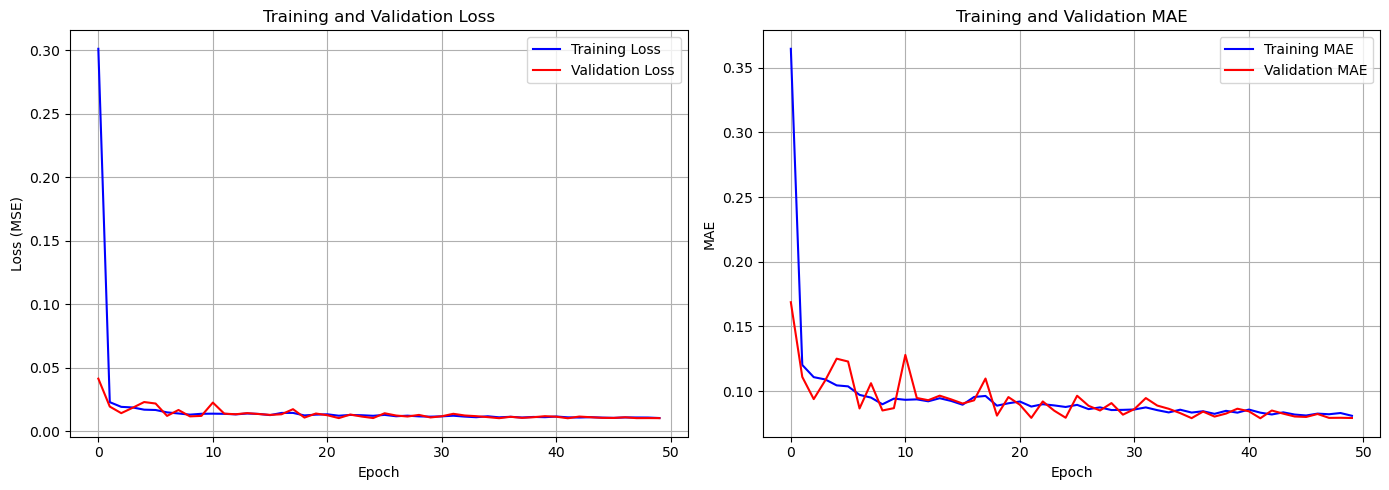

In [17]:
print("\n[9] Generating visualizations...")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(transformer_history.history['loss'], label='Training Loss', color='blue')
axes[0].plot(transformer_history.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# MAE plot
axes[1].plot(transformer_history.history['mae'], label='Training MAE', color='blue')
axes[1].plot(transformer_history.history['val_mae'], label='Validation MAE', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

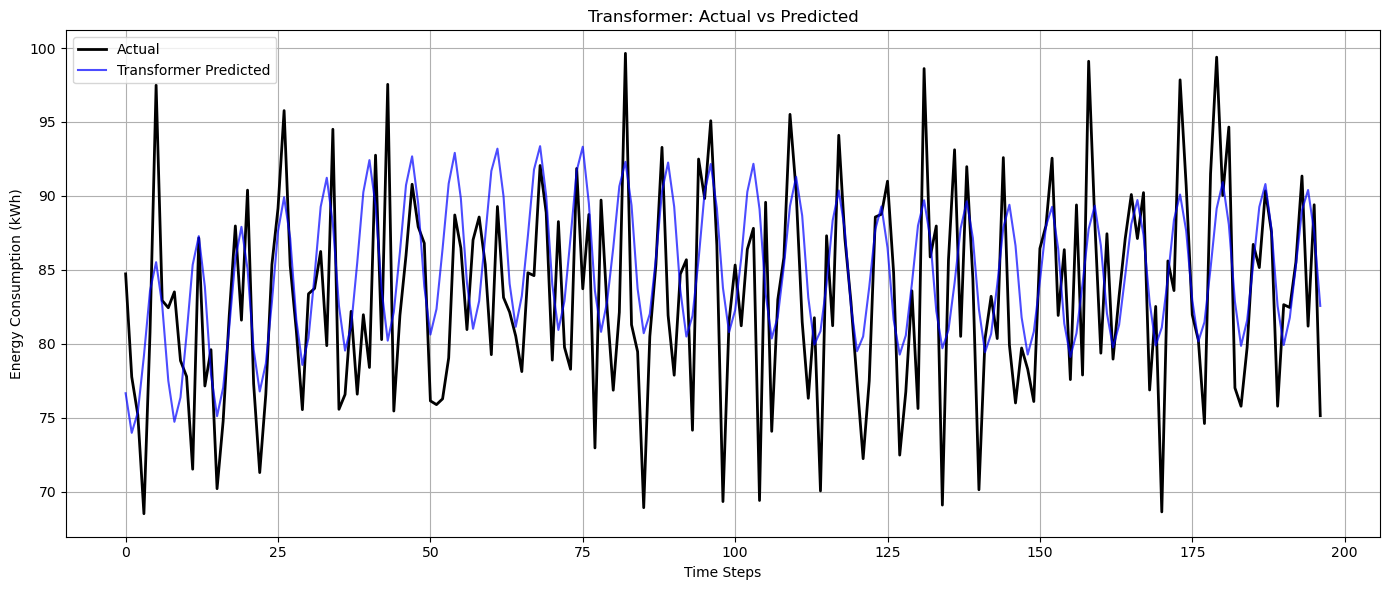

In [18]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual', color='black', linewidth=2)
plt.plot(transformer_pred, label='Transformer Predicted', color='blue', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Transformer: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()

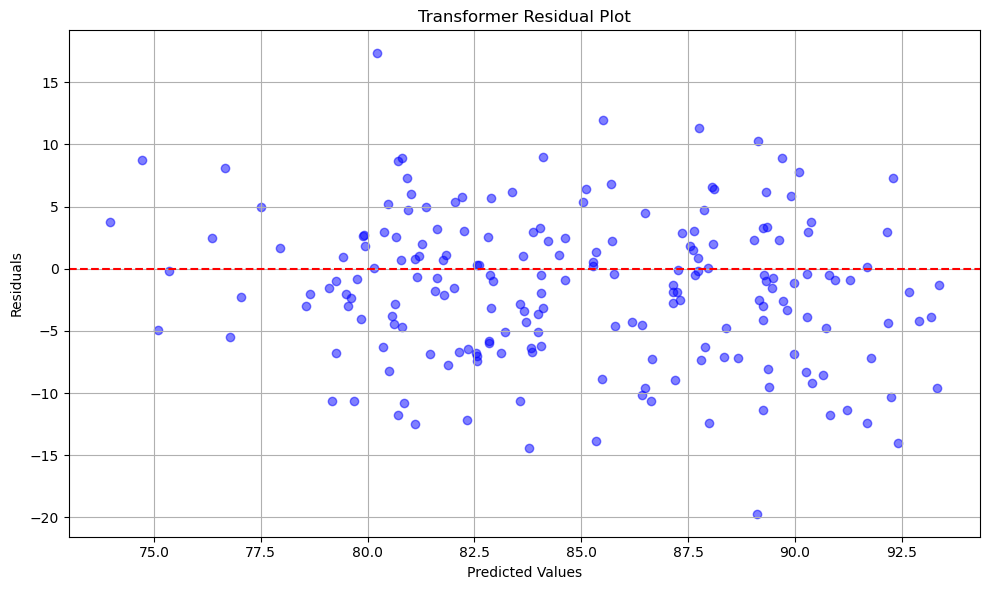

In [19]:
# Plot residuals
plt.figure(figsize=(10, 6))
transformer_residuals = y_test_actual.flatten() - transformer_pred.flatten()
plt.scatter(transformer_pred, transformer_residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Transformer Residual Plot')
plt.grid(True)
plt.tight_layout()

In [20]:
# Visualize attention mechanism (for one sample)
# Extract attention weights from the model
sample_input = X_test[0:1]  # First test sample
print("\n[10] Extracting attention weights for visualization...")

# Create a temporary model to extract attention weights
attention_model = keras.Model(
    inputs=transformer_model.input,
    outputs=[layer.output for layer in transformer_model.layers if 'transformer' in layer.name]
)


[10] Extracting attention weights for visualization...


In [21]:
print("TRANSFORMER TIME SERIES FORECASTING COMPLETE") 
print(f"Positional Encoding: Implemented (sinusoidal)")
print(f"Multi-Head Attention: Implemented (Q, K, V, scaled dot-product)")
print(f"Transformer Blocks: {n_layers} layers")
print(f"Input: Multivariate (3 features)")
print(f"Output: Univariate (1 step ahead)")
print(f"Total Parameters: {transformer_model.count_params():,}")
print(f"Test MAE: {transformer_mae:.4f}")
print(f"Framework: TensorFlow/Keras {tf.__version__}")

TRANSFORMER TIME SERIES FORECASTING COMPLETE
Positional Encoding: Implemented (sinusoidal)
Multi-Head Attention: Implemented (Q, K, V, scaled dot-product)
Transformer Blocks: 2 layers
Input: Multivariate (3 features)
Output: Univariate (1 step ahead)
Total Parameters: 67,265
Test MAE: 4.8382
Framework: TensorFlow/Keras 2.20.0


<hr style="border: 2px solid #4CAF50;"> 
<h3>Extensions and Student Exercises</h3>

<h4>1. Attention Mechanism Variations</h4>
<ul>
  <li><b>More attention heads</b>: Try 2, 4, 8, 16 heads</li>
  <li><b>Masked attention</b>: Implement causal masking for autoregressive prediction</li>
  <li><b>Cross-attention</b>: Add encoder-decoder architecture</li>
  <li><b>Relative positional encoding</b>: Use learned positions instead of sinusoidal</li>
</ul>

<h4>2. Transformer Architecture</h4>
<ul>
  <li><b>Deeper models</b>: Stack 4-6 transformer blocks</li>
  <li><b>Model dimension</b>: Vary d_model (32, 64, 128, 256)</li>
  <li><b>Feed-forward size</b>: Try different d_ff ratios (2×, 4× d_model)</li>
  <li><b>Dropout rates</b>: Experiment with 0.1, 0.2, 0.3</li>
</ul>

<h4>3. Positional Encoding Experiments</h4>
<ul>
  <li><b>Learnable positions</b>: Use trainable embedding instead of sinusoidal</li>
  <li><b>Temporal encoding</b>: Add time-of-day, day-of-week encodings</li>
  <li><b>No positional encoding</b>: Compare performance without positions</li>
  <li><b>2D positional encoding</b>: For spatial-temporal data</li>
</ul>

<h4>4. Training Enhancements</h4>
<ul>
  <li><b>Warmup + cosine decay</b>: Learning rate scheduling</li>
  <li><b>Gradient clipping</b>: Prevent exploding gradients</li>
  <li><b>Label smoothing</b>: Regularization technique</li>
  <li><b>Mixed precision training</b>: Faster training on GPU</li>
</ul>

<h4>5. Advanced Features</h4>
<ul>
  <li><b>Decoder stack</b>: Build full encoder-decoder transformer</li>
  <li><b>Multi-task learning</b>: Predict multiple horizons simultaneously</li>
  <li><b>Attention visualization</b>: Plot attention weights heatmaps</li>
  <li><b>Informer architecture</b>: ProbSparse attention for long sequences</li>
</ul>

<h4>Challenge Problems</h4>
<ol>
  <li>Achieve <b>better performance than LSTM/GRU</b> on your dataset</li>
  <li>Implement <b>full encoder-decoder</b> with cross-attention</li>
  <li>Build <b>hybrid CNN-Transformer</b> architecture</li>
  <li>Apply to <b>long sequences</b> (>100 time steps) with efficient attention</li>
</ol>

<hr>
<h4><center>Happy coding</center></h4>